# 📡 LoRa Network Coverage Analysis with Shadowing

## Background
LoRa (Long Range) is a wireless communication technology designed for IoT applications. It uses different **Spreading Factors (SF)** that trade data rate for range:
- **Higher SF** = Lower data rate, longer range, higher sensitivity
- **Lower SF** = Higher data rate, shorter range, lower sensitivity

**Data Rates (DR)** map to specific spreading factors:
- DR0 ↔ SF10 (longest range, lowest data rate)
- DR1 ↔ SF9
- DR2 ↔ SF8  
- DR3 ↔ SF7 (shortest range, highest data rate)

In [262]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import log10, sqrt

# Set random seed for reproducible results
np.random.seed(42)

# Configure plotting
plt.style.use('default')

print("📡 LoRa Coverage Analysis Notebook Initialized")
print("Ready to simulate LoRa network deployment!")

📡 LoRa Coverage Analysis Notebook Initialized
Ready to simulate LoRa network deployment!


## 1. LoRa Data Rate Parameters

First, let's define the sensitivity levels for different data rates. These values determine how weak a signal each DR can still successfully decode.

In [263]:
# LoRa Data Rate parameters (typical values for 915 MHz)
dr_params = pd.DataFrame({
    "DR": [0, 1, 2, 3],
    "SF": ['SF10', 'SF9', 'SF8', 'SF7'],
    "Sensitivity_dBm": [-136, -133, -131, -128],  # Receiver sensitivity
    "Data_Rate_bps": [976, 1758, 3125, 5469],     # Approximate data rates
    "Color": ['#00429d', '#2e7ebc', '#7ab5d9', '#f2d096']
})

print("LoRa Data Rate Configuration:")
print(dr_params)

LoRa Data Rate Configuration:
   DR    SF  Sensitivity_dBm  Data_Rate_bps    Color
0   0  SF10             -136            976  #00429d
1   1   SF9             -133           1758  #2e7ebc
2   2   SF8             -131           3125  #7ab5d9
3   3   SF7             -128           5469  #f2d096


## 2. Radio System Parameters

These parameters define our LoRa deployment scenario. **Students: You'll modify these later!**

In [264]:
# ========== SYSTEM PARAMETERS (Modify these for exercises!) ==========
num_devices = 1000           # Number of LoRa devices to simulate
radius = 5                   # Deployment area radius (km)
frequency_MHz = 915          # Operating frequency (MHz)

# Gateway parameters
P_tx = 20                    # Transmit power (dBm) - Device to Gateway
G_tx = 2                     # Device antenna gain (dBi)
G_rx = 8                     # Gateway antenna gain (dBi)
L_tx = 0.5                   # Device antenna losses (dB)
L_rx = 1.0                   # Gateway antenna losses (dB)
margin = 10                  # Link margin (dB) - safety margin

# Height parameters
h_tx = 1.5                   # Device height (m) - typical IoT device
h_rx = 15                    # Gateway height (m) - rooftop installation

# Shadowing parameters
shadowing_std = 8            # Shadowing standard deviation (dB) - typical urban
include_shadowing = True     # Enable/disable shadowing simulation

print(f"📍 Simulating {num_devices} devices in {radius} km radius")
print(f"🏗️  Gateway: {h_rx}m height, {G_rx} dBi gain")
print(f"📱 Devices: {h_tx}m height, {G_tx} dBi gain, {P_tx} dBm power")
print(f"🌫️  Shadowing: {'Enabled' if include_shadowing else 'Disabled'} (σ = {shadowing_std} dB)")

📍 Simulating 1000 devices in 5 km radius
🏗️  Gateway: 15m height, 8 dBi gain
📱 Devices: 1.5m height, 2 dBi gain, 20 dBm power
🌫️  Shadowing: Enabled (σ = 8 dB)


## 3. Okumura-Hata Path Loss Model with Shadowing

The **Okumura-Hata model** predicts path loss in urban environments. We'll add **shadowing** (log-normal fading) to model real-world signal variations caused by buildings, terrain, and other obstacles.

**Path Loss Formula:**
```
L(d) = 69.55 + 26.16×log₁₀(f) - 13.82×log₁₀(hb) - a(hm) + (44.9 - 6.55×log₁₀(hb))×log₁₀(d) + X_σ
```

Where:
- `f` = frequency (MHz)
- `hb` = base station height (m) 
- `hm` = mobile height (m)
- `d` = distance (km)
- `X_σ` = shadowing component (random, normally distributed)

In [265]:
def calculate_mobile_antenna_correction(f_MHz, h_mobile):
    """Calculate mobile antenna height correction factor for urban areas"""
    return (1.1 * log10(f_MHz) - 0.7) * h_mobile - (1.56 * log10(f_MHz) - 0.8)

def okumura_hata_path_loss(distance_km, f_MHz, h_base, h_mobile, shadowing_dB=0):
    """Calculate path loss using Okumura-Hata model (urban) with optional shadowing"""
    # Mobile antenna correction
    a_hm = calculate_mobile_antenna_correction(f_MHz, h_mobile)
    
    # Okumura-Hata path loss
    L_p = (69.55 + 26.16 * log10(f_MHz) - 13.82 * log10(h_base) - a_hm + 
           (44.9 - 6.55 * log10(h_base)) * log10(distance_km) + shadowing_dB)
    
    return L_p

def okumura_hata_inverse(L_p, f_MHz, h_base, h_mobile):
    """Calculate maximum distance for given path loss (no shadowing)"""
    a_hm = calculate_mobile_antenna_correction(f_MHz, h_mobile)
    A = 69.55 + 26.16 * log10(f_MHz) - 13.82 * log10(h_base) - a_hm
    B = 44.9 - 6.55 * log10(h_base)
    return 10 ** ((L_p - A) / B)

# Calculate maximum allowable path loss for each DR
dr_params["L_p_max"] = P_tx + G_tx + G_rx - L_tx - L_rx - dr_params["Sensitivity_dBm"] - margin

# Calculate theoretical maximum range (without shadowing)
dr_params["Max_Distance_km"] = dr_params["L_p_max"].apply(
    lambda L: okumura_hata_inverse(L, frequency_MHz, h_rx, h_tx)
)

print("📊 Link Budget Analysis:")
print(dr_params[['DR', 'SF', 'Sensitivity_dBm', 'L_p_max', 'Max_Distance_km']].round(2))

📊 Link Budget Analysis:
   DR    SF  Sensitivity_dBm  L_p_max  Max_Distance_km
0   0  SF10             -136    154.5             4.35
1   1   SF9             -133    151.5             3.61
2   2   SF8             -131    149.5             3.19
3   3   SF7             -128    146.5             2.65


## 4. Device Placement and Coverage Simulation

Now we'll randomly distribute devices and calculate their coverage considering both path loss and shadowing.

In [266]:
# Generate random device positions (uniform distribution in circular area)
r = radius * np.sqrt(np.random.uniform(0, 1, num_devices))
theta = np.random.uniform(0, 2 * np.pi, num_devices)
x = r * np.cos(theta)
y = r * np.sin(theta)
distances_km = np.sqrt(x**2 + y**2)

# Generate shadowing for each device (log-normal fading)
if include_shadowing:
    shadowing = np.random.normal(0, shadowing_std, num_devices)
else:
    shadowing = np.zeros(num_devices)

# Calculate received signal strength and assign data rates
assigned_dr = []
received_power = []

for i, d in enumerate(distances_km):
    # Calculate path loss with shadowing
    if d > 0.001:  # Avoid log(0) for very close devices
        path_loss = okumura_hata_path_loss(d, frequency_MHz, h_rx, h_tx, shadowing[i])
    else:
        path_loss = 32.44 + 20 * log10(frequency_MHz) + 20 * log10(0.001)  # Free space at 1m
    
    # Calculate received power
    P_rx = P_tx + G_tx + G_rx - L_tx - L_rx - path_loss
    received_power.append(P_rx)
    
    # Assign highest possible data rate (lowest SF)
    dr = -1  # Default: unreachable
    for j in reversed(range(4)):  # Start from DR3 (highest rate)
        if P_rx >= dr_params.loc[j, "Sensitivity_dBm"] + margin:
            dr = j
            break
    assigned_dr.append(dr)

# Convert to numpy arrays for easier handling
assigned_dr = np.array(assigned_dr)
received_power = np.array(received_power)

print(f"✅ Simulation complete!")
print(f"📍 {num_devices} devices placed")
print(f"📶 Coverage analysis with {'shadowing' if include_shadowing else 'no shadowing'} performed")

✅ Simulation complete!
📍 1000 devices placed
📶 Coverage analysis with shadowing performed


## 5. Coverage Visualization

Let's visualize the coverage map showing which data rate each device can achieve.

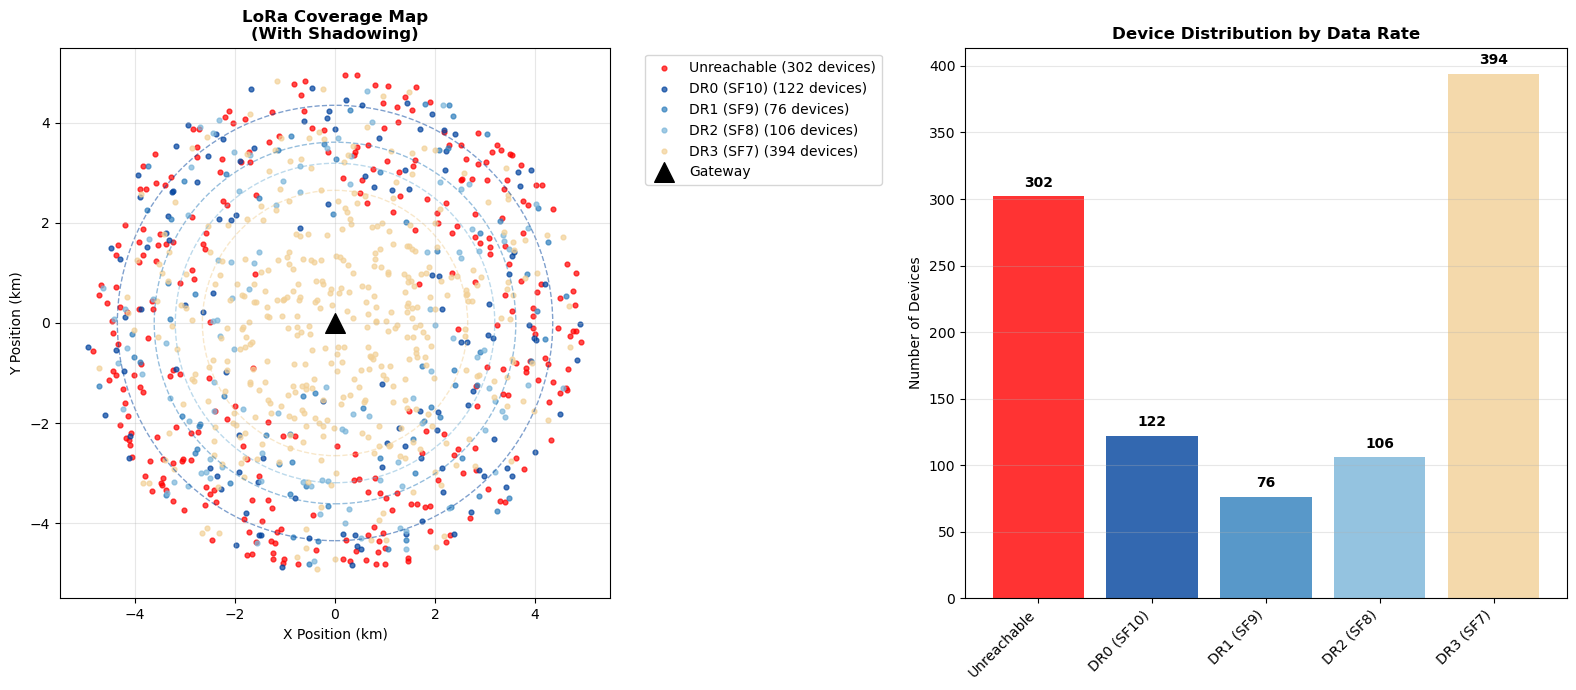

In [267]:
# Create coverage visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Coverage map
colors = ['#00429d', '#2e7ebc', '#7ab5d9', '#f2d096', 'red']
labels = ['DR0 (SF10)', 'DR1 (SF9)', 'DR2 (SF8)', 'DR3 (SF7)', 'Unreachable']

for dr in range(-1, 4):
    idx = assigned_dr == dr
    color_idx = dr if dr >= 0 else 4
    ax1.scatter(x[idx], y[idx], c=colors[color_idx], s=12, alpha=0.7, 
               label=f"{labels[color_idx]} ({np.sum(idx)} devices)")

# Add gateway location
ax1.scatter(0, 0, c='black', s=200, marker='^', label='Gateway', zorder=10)

# Add range circles (theoretical, without shadowing)
for i, row in dr_params.iterrows():
    circle = plt.Circle((0, 0), row['Max_Distance_km'], fill=False, 
                       color=row['Color'], linestyle='--', alpha=0.5, linewidth=1)
    ax1.add_patch(circle)

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_title(f"LoRa Coverage Map\n({'With' if include_shadowing else 'Without'} Shadowing)", fontsize=12, fontweight='bold')
ax1.set_xlabel("X Position (km)")
ax1.set_ylabel("Y Position (km)")
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-radius*1.1, radius*1.1)
ax1.set_ylim(-radius*1.1, radius*1.1)

# Plot 2: Device distribution by DR
dr_counts = pd.Series(assigned_dr).value_counts().sort_index()
dr_labels = [labels[i] if i >= 0 else labels[4] for i in dr_counts.index]
dr_colors = [colors[i] if i >= 0 else colors[4] for i in dr_counts.index]

bars = ax2.bar(range(len(dr_counts)), dr_counts.values, color=dr_colors, alpha=0.8)
ax2.set_xticks(range(len(dr_counts)))
ax2.set_xticklabels(dr_labels, rotation=45, ha='right')
ax2.set_ylabel("Number of Devices")
ax2.set_title("Device Distribution by Data Rate", fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, count in zip(bars, dr_counts.values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{count}',
             #\n({count/num_devices*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Detailed Analysis

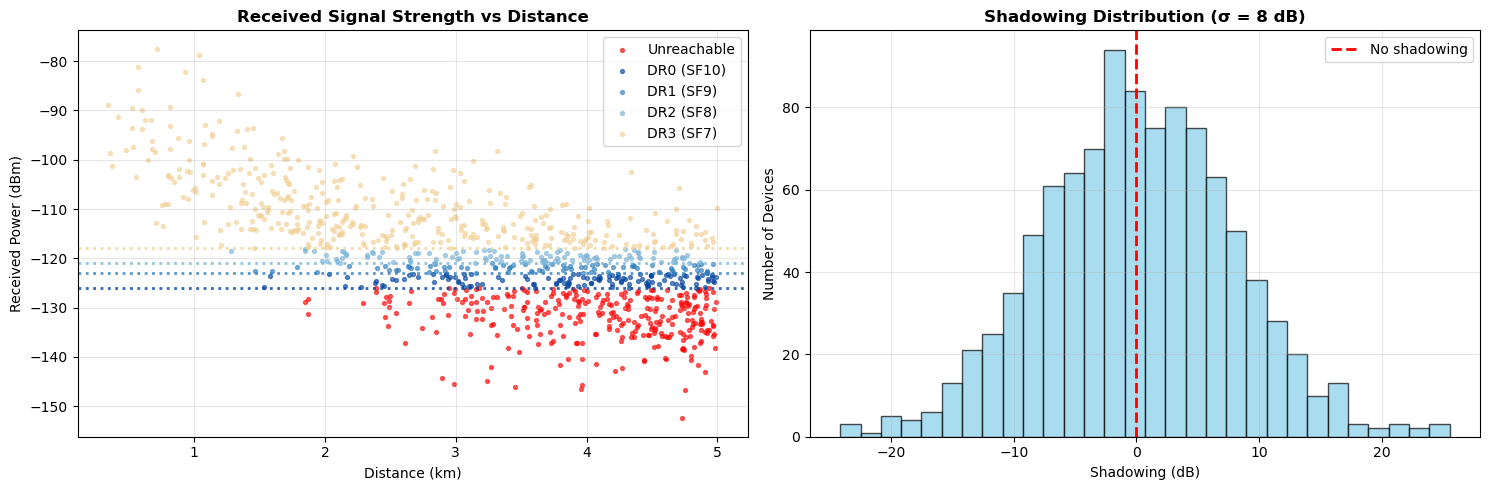


📊 Performance Metrics:
Average Data Rate: DR2.1 (3924 bps)
Total Network Capacity: 2738.7 kbps


In [268]:
# Analyze signal strength distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Received power vs distance
for dr in range(-1, 4):
    idx = assigned_dr == dr
    if np.sum(idx) > 0:
        color_idx = dr if dr >= 0 else 4
        ax1.scatter(distances_km[idx], received_power[idx], 
                   c=colors[color_idx], alpha=0.6, s=8, label=labels[color_idx])

# Add sensitivity thresholds
for i, row in dr_params.iterrows():
    ax1.axhline(y=row['Sensitivity_dBm'] + margin, color=row['Color'], 
               linestyle=':', alpha=0.8, linewidth=2)

ax1.set_xlabel("Distance (km)")
ax1.set_ylabel("Received Power (dBm)")
ax1.set_title("Received Signal Strength vs Distance", fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Shadowing effect histogram
if include_shadowing:
    ax2.hist(shadowing, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No shadowing')
    ax2.set_xlabel("Shadowing (dB)")
    ax2.set_ylabel("Number of Devices")
    ax2.set_title(f"Shadowing Distribution (σ = {shadowing_std} dB)", fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'Shadowing\nDisabled', transform=ax2.transAxes, 
             ha='center', va='center', fontsize=16, style='italic')
    ax2.set_title("Shadowing Distribution", fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate average data rate
valid_dr = assigned_dr[assigned_dr >= 0]
if len(valid_dr) > 0:
    avg_dr = np.mean(valid_dr)
    avg_data_rate = np.mean([dr_params.loc[dr, 'Data_Rate_bps'] for dr in valid_dr])
    print(f"\n📊 Performance Metrics:")
    print(f"Average Data Rate: DR{avg_dr:.1f} ({avg_data_rate:.0f} bps)")
    print(f"Total Network Capacity: {avg_data_rate * len(valid_dr) / 1000:.1f} kbps")